SVIGP
[对应论文](https://arxiv.org/pdf/1309.6835)
[对应code](https://github.com/ratschlab/SVGP-VAE/blob/main/SVIGP_Hensman_model.py)


In [23]:
import os
import time
import sys
sys.path.append('..')  # Add parent folder to sys.path

import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt

from kernel import ARDKernel2
# from torch.autograd import Variable
import torch.optim as optim
# Variational Sparse Gaussian Processes

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Fixing strange error if run in MacOS

JITTER = 1e-4
torch.manual_seed(1)  
EPS = 1e-10
PI = 3.1415
softplus = nn.Softplus()

In [24]:
#train_set
xtr = torch.rand(100, 1)
ytr = ((6*xtr - 2)**2) * torch.sin(12*xtr - 4) + torch.randn(100, 1) * 0.01

#test_set
xte = torch.linspace(0, 1, 100).view(-1,1)
yte = ((6*xte - 2)**2) * torch.sin(12*xte - 4)

In [25]:
#subset_set_of_training_set
num_inducing=20
subset_indices = torch.randperm(len(xtr))[:num_inducing]
xm = xtr[subset_indices]
ym = ytr[subset_indices]
#xm=nn.Parameter(torch.rand(num_inducing,1))
#plt.plot(xte.numpy(), yte.numpy(), 'r-', alpha = 0.5)
#plt.plot(xm.numpy(), ym.numpy(), 'b+')

In [26]:
log_beta = nn.Parameter(torch.ones(1) * 4)# this is a large noise. we optimize to shrink it to a proper value.

In [27]:
kernel=ARDKernel2(1)

The lowerbound introduced by Hensman et al. [2013]
$$
\mathcal{L} = \mathbb{E}_{q(\mathbf{f}, \mathbf{u})}[\log p(\mathbf{y}|\mathbf{f})] - \mathrm{KL}[q(\mathbf{u})||p(\mathbf{u})]
$$
allow us to apply mini-batch learning on sparse GP

In [28]:
mean=ym.clone()+(torch.randn(num_inducing, 1) * 1) #如果这里initialize成0，均值就不动，但是loss对均值的偏导不是0，很奇怪！
q_u_mean=nn.Parameter(mean)
#q_u_mean=nn.Parameter(torch.zeros(xm.size(0),1))
chole=nn.Parameter(torch.rand(xm.size(0),1))

Now we want to initialize parameter q_u_S, which is the covariance matrix for $q(u)$. So we want to keep q_u_S as positive definite matrix

$$
\mathcal{L} = \sum_{i=1}^{n} \left\{ \log \mathcal{N}\left(y_i \middle| k_i^T K_{mm}^{-1} m, \beta^{-1}\right) - \frac{1}{2} \beta k_{i,i} - \frac{1}{2} \text{tr}(S \Lambda_i) \right\} - \mathrm{KL}[q(\mathbf{u}) \parallel p(\mathbf{u})]
$$
$$
\mathcal{L} = \sum_{i=1}^{n} \left\{-\frac{1}{2} \log(2 \pi \beta^{-1}) - \frac{\beta}{2} \left((y_i - k_i^T K_{mm}^{-1} m)^2 \right)- \frac{1}{2} \beta k_{i,i} - \frac{1}{2} \text{tr}(S \Lambda_i) \right\} - \mathrm{KL}[q(\mathbf{u}) \parallel p(\mathbf{u})]
$$
And:
$$
\mathrm{KL}[q(\mathbf{u}) \parallel p(\mathbf{u})] = \frac{1}{2} \left( \text{tr}(\mathbf{K_{mm}}^{-1}\mathbf{S}) + \mathbf{m}^T \mathbf{K_{mm}}^{-1} \mathbf{m} - \log\left(\frac{|\mathbf{S}|}{|\mathbf{K_{mm}}|}\right) - d \right)
$$
[reference for KL](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)

$\tilde{k}_{i,i}$ is the ith diagonal element of $\tilde{\mathbf{K}}$

$$
\tilde{\mathbf{K}} = \mathbf{K}_{nn} - \mathbf{K}_{nm} \mathbf{K}_{mm}^{-1} \mathbf{K}_{mn}
$$
$\mathbf{k}_i$ is a vector representing the $i$-th column of $\mathbf{K}_{mn}$ and $\Lambda_i$is defined as:

$$\Lambda_i = \beta \mathbf{K}_{mm}^{-1} \mathbf{k}_i \mathbf{k}_i^\top \mathbf{K}_{mm}^{-1} $$


In [29]:
def negative_lower_bound(q_u_mean,chole,xm,xtr,ytr,kernel,log_beta):
    b=xtr.size(0) #batch size

    k_mm=kernel(xm, xm)+JITTER * torch.eye(xm.size(0))
    k_mn=kernel(xm, xtr)
    Lm = torch.linalg.cholesky(k_mm)
    k_nm=k_mn.t()

    gamma,_ = torch.triangular_solve(k_mn, Lm, upper = False)
    K=gamma.t()@gamma
    K_tilda=(kernel(xtr, xtr).diag()-K.diag()).view(-1,1)

    #Option 1
    #k_mm_inv=torch.inverse(k_mm)

    #Option 2 More efficient and stable
    k_mm_inv= torch.cholesky_inverse(Lm)

    q_u_S=chole@chole.t()+JITTER * torch.eye(xm.size(0))
    Ls=torch.linalg.cholesky(q_u_S)
    #Ls=flat_to_trian(chole)
    #q_u_S=Ls@Ls.t()


    A_i=log_beta.exp()*(k_mm_inv@k_mn@k_nm@k_mm_inv)
    SA_i=q_u_S@A_i
    tr_SA_i=SA_i.diag()
    L=-0.5*b*torch.log(2*torch.tensor(PI))+0.5*b*torch.log(log_beta.exp())\
      -0.5*log_beta.exp()*((ytr-k_nm@k_mm_inv@q_u_mean)**2).sum(dim = 0).view(-1,1)\
      -0.5*log_beta.exp()*K_tilda.sum(dim = 0).view(-1,1)-0.5*(tr_SA_i.sum(dim = 0).view(-1,1))


    # compute KL
    logdetS = 2 * Ls.diag().log().sum()
    logdetKmm=2*Lm.diag().log().sum()
    k_mm_invS=k_mm_inv@q_u_S

    KL =  0.5*k_mm_invS.diag().sum(dim = 0).view(-1,1)+ 0.5*(q_u_mean.t()@k_mm_inv@q_u_mean)-0.5*logdetS+ 0.5*logdetKmm -0.5*num_inducing

    return KL,L,k_mm_inv


In [30]:
%%time
num_epochs = 500
optimizer = optim.Adam([q_u_mean, chole, log_beta] + list(kernel.parameters()), lr=0.01)
for i in range(num_epochs):
    optimizer.zero_grad()
    KL,L,k_mm_inv=negative_lower_bound(q_u_mean,chole,xm,xtr,ytr,kernel,log_beta)
    loss=KL-L
    loss.backward()
    optimizer.step()

        # Print kernel parameters
        #for name, param in kernel.named_parameters():
            #if param.requires_grad:
                #print(f'{name}: {param.data}')

        #print('log_beta:', log_beta.data)
    if i % 10 == 0:

        print('iter', i, 'nll:{:.5f}'.format(loss.item()))



iter 0 nll:568208.93750
iter 10 nll:469223.87500
iter 20 nll:355631.75000
iter 30 nll:242054.42188
iter 40 nll:154911.04688
iter 50 nll:103406.96094
iter 60 nll:74823.10156
iter 70 nll:57219.84375
iter 80 nll:45350.22266
iter 90 nll:37082.57422
iter 100 nll:30982.67773
iter 110 nll:26317.56250
iter 120 nll:22622.34180
iter 130 nll:19619.93164
iter 140 nll:17198.06836
iter 150 nll:15191.30859
iter 160 nll:13510.30664
iter 170 nll:12149.35449
iter 180 nll:11004.38867
iter 190 nll:10037.30176
iter 200 nll:9219.52246
iter 210 nll:8506.17383
iter 220 nll:7883.75391
iter 230 nll:7343.30762
iter 240 nll:6880.33984
iter 250 nll:6471.58838
iter 260 nll:6105.92969
iter 270 nll:5778.79443
iter 280 nll:5479.62207
iter 290 nll:5214.91748
iter 300 nll:4974.21631
iter 310 nll:4755.23730
iter 320 nll:4564.42676
iter 330 nll:4373.60400
iter 340 nll:4196.37451
iter 350 nll:4050.21973
iter 360 nll:3901.72217
iter 370 nll:3767.79883
iter 380 nll:3640.25098
iter 390 nll:3522.23462
iter 400 nll:3415.30200
i

In [31]:
_,_,k_mm_inv=negative_lower_bound(q_u_mean,chole,xm,xtr,ytr,kernel,log_beta)
def forward(xm,xte,q_u_mean,kernel, log_beta):
    K_tt=kernel(xte,xte)
    K_tm=kernel(xte,xm)
    K_mt= K_tm.t()
    ypred=(K_tm@k_mm_inv)@q_u_mean
    #yvar=K_tt-K_tm@K_mm_inv@K_mt+K_tm@K_mm_inv@A_m@K_mm_inv@K_mt
    #yvar = yvar.diag().view(-1,1)
    return ypred#,yvar

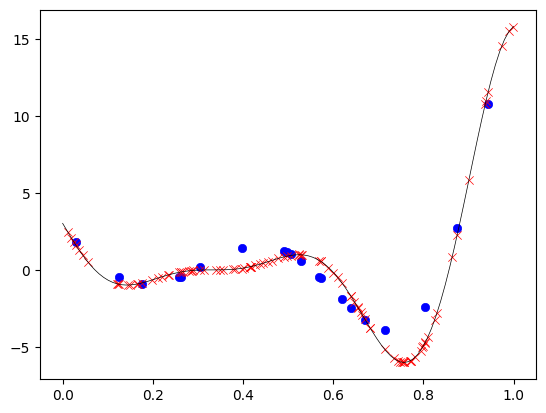

In [32]:
#经过训练后
plt.plot(xte.cpu().numpy(), yte.cpu().numpy(), label='Latent function', c='k', lw=0.5)
plt.scatter(xm.cpu().numpy(), q_u_mean.cpu().detach().numpy(), label='Prediction', c='b',lw=0.5)
# plot training data
plt.scatter(xtr.cpu().numpy(), ytr.cpu().numpy(), label='Training data', c='r', lw=0.5, marker='x')


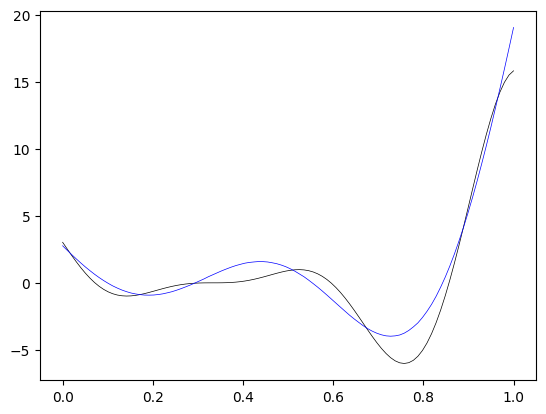

In [33]:
ypred=forward(xm,xte,q_u_mean,kernel, log_beta)
plt.plot(xte.numpy(), yte.numpy(), label='Latent function', c='k', lw=0.5)
plt.plot(xte.numpy(), ypred.detach().numpy(), label='Prediction', c='b',lw=0.5)